In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf 
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
sys.path.append("../src/mgpt/")
import torch
import torch.nn as nn

### Loading the torch Dataset

In [4]:
from dataset import AstroDataset

In [5]:
data = AstroDataset("../data/train_data.txt", max_length=4, batch_size=3, stride=1)
my_data = data.create_dataloader(shuffle=False)

In [6]:
data_iter = iter(my_data)
first_batch = next(data_iter)
print("First_batch shape", np.shape(first_batch))
print("First Batch:", first_batch)

First_batch shape (2, 3, 4)
First Batch: [tensor([[40720,  7890,    14, 27432],
        [ 7890,    14, 27432,    62],
        [   14, 27432,    62,  7890]]), tensor([[ 7890,    14, 27432,    62],
        [   14, 27432,    62,  7890],
        [27432,    62,  7890,    13]])]


In [7]:
from model import GenerateEmbeddings, CausalAttention, MultiHeadAttention

In [8]:
vocab_size = 1000
embed_dim = 4
max_seq_len = 3

embedding_layer = GenerateEmbeddings(vocab_size, embed_dim, max_seq_len)

In [9]:
# Batch of 2 sequences, each 6 tokens long
input_ids = torch.randint(0, vocab_size, (2, 3))
print(input_ids)
output = embedding_layer(input_ids)
print("embedding shape:", output.shape)
print("embeddings:", output[0,0])

tensor([[ 31, 391, 123],
        [802, 451,  48]])
embedding shape: torch.Size([2, 3, 4])
embeddings: tensor([-1.0645,  1.3672,  1.2847, -1.2788], grad_fn=<SelectBackward0>)


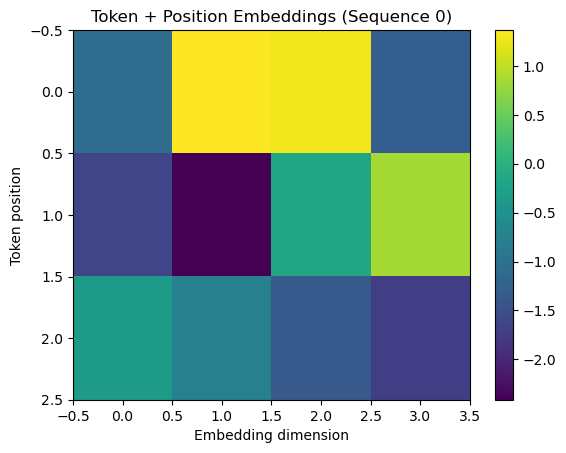

In [10]:
import matplotlib.pyplot as plt

plt.imshow(output[0].detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Token + Position Embeddings (Sequence 0)")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.show()

#### No idea what this means hahaha

### Multi-Head Attention

In [11]:
multi_head_attn = MultiHeadAttention(embed_dim=4, num_heads=2,
                                     context_length=3,
                                     dropout=0.5)

output_attn = multi_head_attn(output)
print("Output Attention shape:", output_attn.shape)

Output Attention shape: torch.Size([2, 3, 4])


In [14]:
multi_head_attn.eval()            # turn off dropout for determinism
_ = multi_head_attn(output)       # run a forward once
print(multi_head_attn.last_attn.shape)          # -> [B, H, T, T]
print(multi_head_attn.last_attn[0, 0].sum(-1))  # row sums ≈ tensor([1., 1., ..., 1.])

torch.Size([2, 2, 3, 3])
tensor([1., 1., 1.])


In [18]:
A = multi_head_attn.last_attn[0, 0]  # [T, T], head 0, batch 0
print("max future mass:", A.triu(1).max().item())   # elements above diagonal

max future mass: 0.0


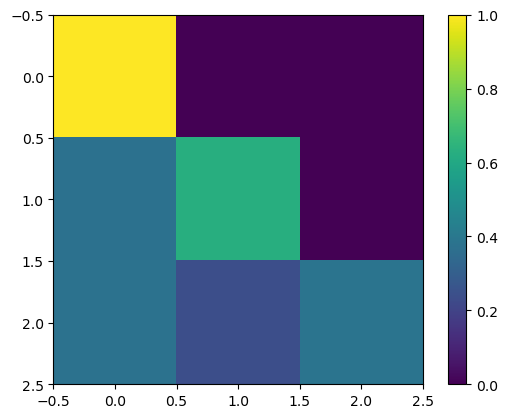

In [20]:
plt.imshow(A, cmap='viridis')
plt.colorbar()

### Checking the AstroGPT

In [2]:
from model import Mini_AstroGPT_Model

In [3]:
params_dict = {
    "vocab_size": 50257,
    "embed_dim": 64,
    "context_dim": 16,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.0,
}

model = Mini_AstroGPT_Model(params_dict)
batch_size = 2
max_seq_len = 8
input_ids = torch.randint(0, params_dict["vocab_size"], (batch_size, max_seq_len))

logits = model(input_ids)
print("logits:", logits.shape)

# 2) causal mask sanity (one block’s MHA)
blk = model.transformer_blocks[0].attention
blk.eval()
_ = blk(model.embed_layer(input_ids))         # run once
A = blk.last_attn[0,0]
print("row sums ~1:", A.sum(-1))      # ~1.0
print("max future mass:", A.triu(1).max().item())  # ~0.0

logits: torch.Size([2, 8, 50257])
row sums ~1: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
max future mass: 0.0
